# Replicating [Simple Black-box Adversarial Attacks](https://arxiv.org/pdf/1905.07121.pdf)

This notebook uses the replicate of the Simple Black-box Adversarial attack proposed by Guo et al. [More explanation]

Folder of the ImageNet ILSVRC2012 validation dataset, its labels in the meta data. Note: After accessing [login-access to the ImagNet website](https://image-net.org/signup.php), go to the [ImageNet 2012 version](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) and download
* Development kit (Task 1 & 2). 2.5MB. - containing the labels and the meta data
* Validation images (all tasks). 6.3GB. - the validation images

Extract both and assign the locations of the folder and files to the corresponding Constants:

In [1]:
IMAGE_FOLDER = "../../../data/val"
LABEL_FILE = "../../../data/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../data/ILSVRC2012_devkit_t12/data/meta.mat"

Let's load the meta data (mapping image id to label). The labels are not consitent: the indices from the official website do not match the indices from the PyTorch, pre-trained ResNet. So let's get them combined into one meta dataframe. The resnet image class data conversion ("imagenet_class_index.json") was taken from [here](https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json).

In [2]:
from mat4py import loadmat
import pandas as pd
import json

meta = pd.DataFrame.from_dict(loadmat(META_FILE)["synsets"])
meta.set_index("WNID", inplace=True)
with open("imagenet_class_index.json", "r") as file:
    pytorch_label_indices = json.load(file)

for key, (wnid, label) in pytorch_label_indices.items():
    meta.loc[wnid, "key"] = key
    meta.loc[wnid, "label"] = label.replace("_"," ")
meta.set_index("key", inplace=True)

Let's get the data.

In [3]:
from imagenet import ImageNetDataSet
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, transform=preprocess)

And let's see if everything worked out as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


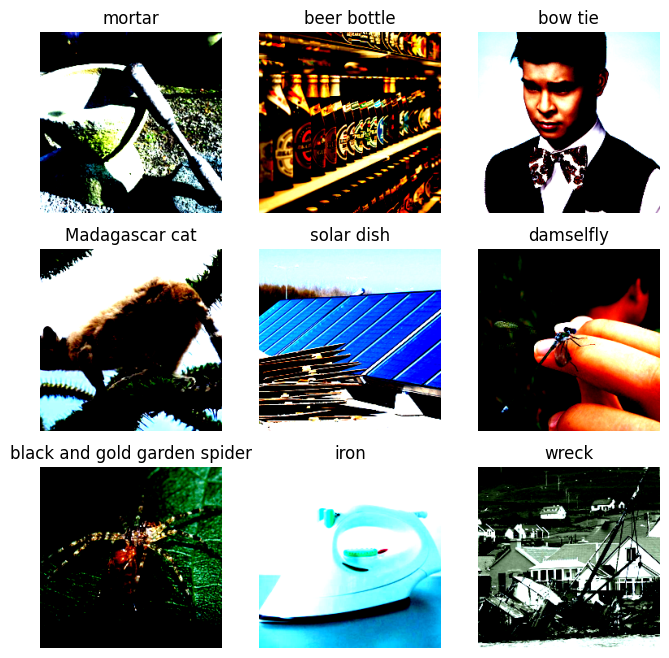

In [4]:
import torch
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(meta.loc[meta["ILSVRC2012_ID"] == int(label), "label"].iloc[0])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

## Classifying with pre-trained ResNet50

In [5]:
import torch
import numpy as np

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

for _ in range(5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 3)
    print(f"The actual label is {int(label)} and the model thinks it is {[meta.loc[f'{int(pred)}', 'ILSVRC2012_ID'] for pred in predictions]} with probability {probs}")

Using cache found in /home/eko/.cache/torch/hub/pytorch_vision_v0.10.0
/home/eko/Documents/Research/paper_replications/replicating-simple-blackbox-attack/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eko/Documents/Research/paper_replications/replicating-simple-blackbox-attack/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  